# Neural Network to predict success of Kickstarter campaigns in 2017

A two layer ANN is trained and evaluated for a regression task on a preprocessed version of the Kickstarter dataset found on: https://www.kaggle.com/kemical/kickstarter-projects

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
%matplotlib inline

# basic settings
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (5, 5)
sns.set_palette('husl')

In [4]:
def bmplot(yt, xt, X):
    ''' Function plots matrix X as image with lines separating fields. '''
    plt.imshow(X,interpolation='none',cmap='bone')
    plt.xticks(range(0,len(xt)), xt)
    plt.yticks(range(0,len(yt)), yt)
    for i in range(0,len(yt)):
        plt.axhline(i-0.5, color='black')
    for i in range(0,len(xt)):
        plt.axvline(i-0.5, color='black')
        
def feature_selector_lr(X,y,cvf=10,features_record=None,loss_record=None,display=''):
    ''' Function performs feature selection for linear regression model using
        'cvf'-fold cross validation. The process starts with empty set of
        features, and in every recurrent step one feature is added to the set
        (the feature that minimized loss function in cross-validation.)

        Parameters:
        X       training data set
        y       vector of values
        cvf     number of crossvalidation folds

        Returns:
        selected_features   indices of optimal set of features
        features_record     boolean matrix where columns correspond to features
                            selected in subsequent steps
        loss_record         vector with cv errors in subsequent steps
        
        Example:
        selected_features, features_record, loss_record = ...
            feature_selector_lr(X_train, y_train, cvf=10)
            
    ''' 
    y = y.squeeze()
    # first iteration error corresponds to no-feature estimator
    if loss_record is None:
        loss_record = np.array([np.square(y-y.mean()).sum()/y.shape[0]])
    if features_record is None:
        features_record = np.zeros((X.shape[1],1))

    # Add one feature at a time to find the most significant one.
    # Include only features not added before.
    selected_features = features_record[:,-1].nonzero()[0]
    min_loss = loss_record[-1]
    if display is 'verbose':
        print(min_loss)
    best_feature = False
    for feature in range(0,X.shape[1]):
        if np.where(selected_features==feature)[0].size==0:
            trial_selected = np.concatenate((selected_features,np.array([feature])),0).astype(int)
            # validate selected features with linear regression and cross-validation:
            trial_loss = glm_validate(X[:,trial_selected],y,cvf)
            if display is 'verbose':
                print(trial_loss)
            if trial_loss<min_loss:
                min_loss = trial_loss 
                best_feature = feature

    # If adding extra feature decreased the loss function, update records
    # and go to the next recursive step
    if best_feature is not False:
        features_record = np.concatenate((features_record, np.array([features_record[:,-1]]).T), 1)
        features_record[best_feature,-1]=1
        loss_record = np.concatenate((loss_record,np.array([min_loss])),0)
        selected_features, features_record, loss_record = feature_selector_lr(X,y,cvf,features_record,loss_record)
        
    # Return current records and terminate procedure
    return selected_features, features_record, loss_record

def glm_validate(X,y,cvf=10):
    ''' Validate linear regression model using 'cvf'-fold cross validation.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns MSE averaged over 'cvf' folds.

        Parameters:
        X       training data set
        y       vector of values
        cvf     number of crossvalidation folds        
    '''
    y = y.squeeze()
    CV = model_selection.KFold(n_splits=cvf, shuffle=True)
    validation_error=np.empty(cvf)
    f=0
    for train_index, test_index in CV.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        m = linear_model.LinearRegression(fit_intercept=True).fit(X_train, y_train)
        validation_error[f] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]
        f=f+1
    return validation_error.mean()

### Artificial neural network

An artificial neural network model is fitted to the data. The number of hidden neurons is chosen as a complexity-controlling parameter and a two-level cross-validation to both optimize the parameter and estimate the generalization error is applied.

### Load, preprocess and visualize dataset

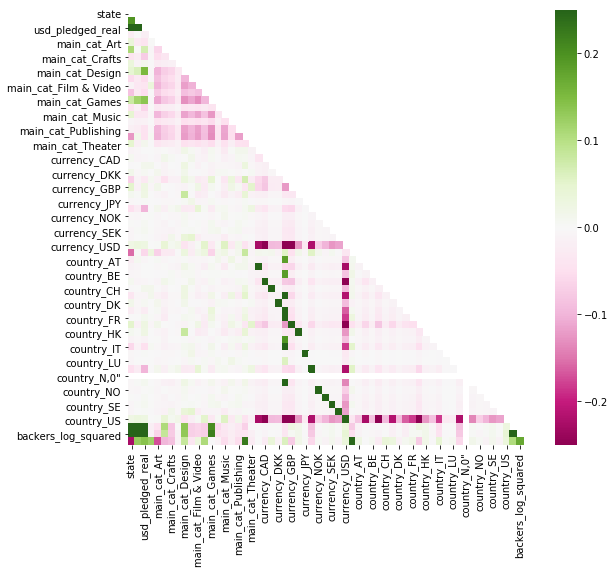

In [7]:
data=pd.read_csv('kickstarter-projects-cleaned_data.csv')

attributes = list(data.columns.values)

# Create index of unwanted attributes
A = np.array([0])
B = np.arange(5,164)
C = np.arange(195,206)
D = np.array([193])
index = list(np.concatenate([A,B,C,D]))
mask = [attributes[i] for i in index]

# Cut down data set to only 2017 data
df17 = data[data.yearlaunched_2017 == 1]

# Remove unwanted attributes
df17 = df17.drop(mask,axis = 1)

df17['backers_log']=np.log10(df17['backers']+1)
df17['backers_log_squared']=np.power(np.log10(df17['backers']+1),2)
df17['usd_goal_real_log']=np.log10(df17['usd_goal_real']+1)
df17['usd_pledged_real']=np.log10(df17['usd_pledged_real']+1)


# Visualize Correlation Matrix

corr = df17.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(9,8))
sns.heatmap(corr, mask=mask, cmap='PiYG', vmin=-0.25, vmax=0.25);

### Selecting relevant features and splitting the data

Creating a training- and a testing subset of the dataframe. Given the amount of data, a train-test-ratio of 4:1 is chosen (eg. 80% training, 20% testing).  
The features that were included the most in the feedforward selection shown above were chosen as inputs for the neural network.

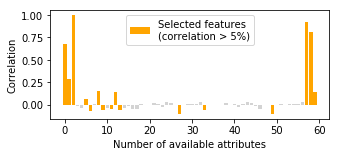

In [249]:
my_color=np.where(abs(corr['usd_pledged_real']) > 0.05, 'orange', 'lightgray')

f, ax = plt.subplots(figsize=(5,2))
ax.bar(np.arange(len(corr['usd_pledged_real'])), corr['usd_pledged_real'], 
       color=my_color, label='Selected features\n(correlation > 5%)')
ax.set(ylabel='Correlation', xlabel='Number of available attributes');
plt.legend();
plt.savefig('ANN_feature_selection.png', dpi = 300)

In [44]:
# features that correlate to the target by more than 5% are selected
significant_features = list(df17.columns[abs(corr['usd_pledged_real']) > 0.05])
df = df17[significant_features]

In [46]:
df.describe()

,state,backers,usd_pledged_real,main_cat_Comics,main_cat_Crafts,main_cat_Design,main_cat_Fashion,main_cat_Food,main_cat_Games,main_cat_Journalism,currency_MXN,duration,country_MX,backers_log,backers_log_squared,usd_goal_real_log
count,"43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00","43,424.00"
mean,0.43,144.30,2.66,0.04,0.03,0.11,0.08,0.06,0.13,0.01,0.03,31.48,0.03,1.25,2.31,3.70
std,0.49,769.41,1.42,0.20,0.17,0.31,0.27,0.24,0.33,0.11,0.16,11.44,0.16,0.86,2.57,0.74
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.19
25%,0.00,2.00,1.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.04,0.00,0.48,0.23,3.24
50%,0.00,16.00,2.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.42,0.00,1.23,1.51,3.70
75%,1.00,75.00,3.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,32.92,0.00,1.88,3.54,4.18
max,1.00,"43,733.00",6.85,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,60.00,1.00,4.64,21.54,8.03


In [47]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)
    # df_red[['usd_pledged_real']].values.astype(np.float32)

In [ ]:
df17.drop('usd_goal_real', axis=1)

In [1]:
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics
from scipy.stats import zscore
import os
import io
import requests
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras.layers.core import Dense, Activation, Dropout

history = History()

Using TensorFlow backend.


In [115]:
dfr = df[0:6000] # reduced dataframe for faster training

x,y = to_xy(dfr, 'usd_pledged_real')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.02, beta_1=0.9,
beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer= adam)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
# checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 4800 samples, validate on 1200 samples
Epoch 1/1000
 - 3s - loss: 81.8304 - val_loss: 3.5195
Epoch 2/1000
 - 1s - loss: 1.5112 - val_loss: 2.3414
Epoch 3/1000
 - 1s - loss: 1.2456 - val_loss: 0.6485
Epoch 4/1000
 - 1s - loss: 1.7784 - val_loss: 0.8873
Epoch 5/1000
 - 1s - loss: 0.6456 - val_loss: 0.5331
Epoch 6/1000
 - 1s - loss: 0.4880 - val_loss: 0.4125
Epoch 7/1000
 - 1s - loss: 0.4038 - val_loss: 0.3550
Epoch 8/1000
 - 1s - loss: 0.3507 - val_loss: 0.3307
Epoch 9/1000
 - 1s - loss: 0.3104 - val_loss: 0.2605
Epoch 10/1000
 - 1s - loss: 0.3366 - val_loss: 0.3344
Epoch 11/1000
 - 1s - loss: 0.3598 - val_loss: 0.2453
Epoch 12/1000
 - 1s - loss: 0.2884 - val_loss: 0.2345
Epoch 13/1000
 - 1s - loss: 0.2567 - val_loss: 0.3027
Epoch 14/1000
 - 1s - loss: 0.2416 - val_loss: 0.2052
Epoch 15/1000
 - 1s - loss: 0.2341 - val_loss: 0.1997
Epoch 16/1000
 - 1s - loss: 0.2209 - val_loss: 0.1981
Epoch 17/1000
 - 1s - loss: 0.2233 - val_loss: 0.1785
Epoch 18/1000
 - 1s - loss: 0.2222 - val_l

### Error measurement

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $  

Keep in mind, that the target is the __base-10 logarithm__ of money pledged in USD.

In [55]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction', alpha=0.5)
    plt.ylabel('output')
    plt.legend()
    plt.show()

Final score 
(MSE): 0.13994330167770386
(RMSE): 0.37408995628356934


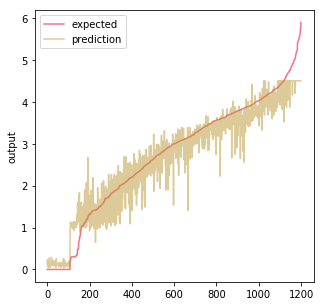

In [116]:
# Predict
pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = metrics.mean_squared_error(pred,y_test)
print("Final score \n(MSE): {}".format(score))
print("(RMSE): {}".format(np.sqrt(score)))

chart_regression(pred.flatten(),y_test)

## 5-fold crossvalidation for generalization error estimation

Fold #1
Epoch 00040: early stopping
Fold score (MSE): 0.14


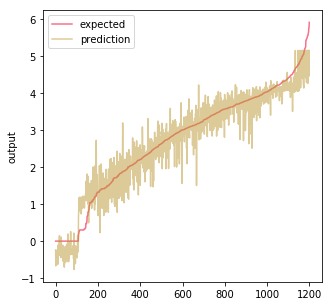

Fold #2
Epoch 00016: early stopping
Fold score (MSE): 0.22


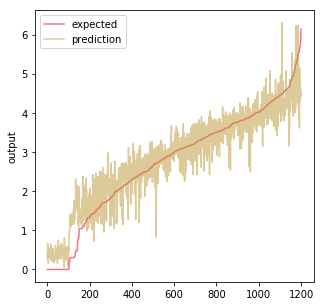

Fold #3
Epoch 00012: early stopping
Fold score (MSE): 0.17


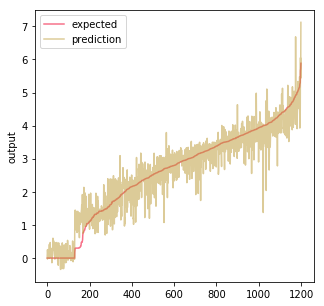

Fold #4
Epoch 00012: early stopping
Fold score (MSE): 0.28


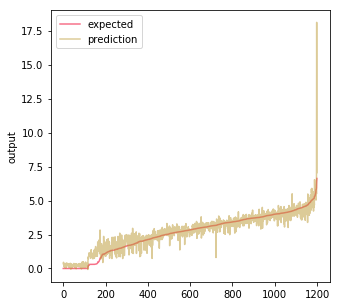

Fold #5
Epoch 00025: early stopping
Fold score (MSE): 0.26


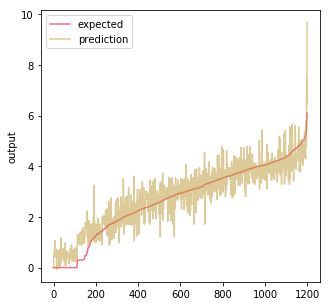

Final, out of sample score (MSE): 0.22


In [120]:
# CROSS VALIDATION

dfr = df[0:6000] # reduced dataframe for faster training

# Shuffle
np.random.seed(42)
dfr = dfr.reindex(np.random.permutation(dfr.index))
dfr.reset_index(inplace=True, drop=True)


# Encode to a 2D matrix for training
x,y = to_xy(dfr, 'usd_pledged_real')

# Cross-Validate
kf = KFold(5)

oos_y = []
oos_pred = []
fold = 0

# generalization error estimation
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    model = Sequential()
    model.add(Dense(30, input_dim=x.shape[1], activation='relu', 
                    bias_regularizer=regularizers.l2(0.02)))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=0.01, beta_1=0.9,
    beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer= adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    # checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

    pred = model.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = metrics.mean_squared_error(pred,y_test)
    print("Fold score (MSE): {0:.2f}".format(score))

    chart_regression(pred.flatten(),y_test)

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = metrics.mean_squared_error(oos_pred,oos_y)
print("Final, out of sample score (MSE): {0:.2f}".format(score))    

# Write the cross-validated prediction
# oos_y = pd.DataFrame(oos_y)
# oos_pred = pd.DataFrame(oos_pred)
# oosDF = pd.concat( [dfr, oos_y, oos_pred],axis=1 )
# oosDF.to_csv(filename_write,index=False)

## Two layer crossvalidation for model selection and generalization error estimation

In [122]:
dfr = df

# K-fold crossvalidation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True,random_state=1)

K_in = 4 
CV_in = model_selection.KFold(n_splits=K_in,shuffle=True,random_state=2)

# Set up emtpy vector to gather test errors
test_errors_ann = np.empty((K,1))

# Encode to a 2D matrix for training
x,y = to_xy(dfr, 'usd_pledged_real')

# complexity controlling parameter:
n_neurons = np.array([10, 20, 30])

S = len(n_neurons)

oos_y = []
oos_pred = []
fold = 0

#Initialize k for k'th split
k = 0

# ------ OUTER LAYER ------
# Create splits, begin loop 
for train_index, test_index in CV.split(x):
    
    # Extract training and test set for the current outer fold
    X_train, y_train = x[train_index,:], y[train_index]
    X_test, y_test = x[test_index,:], y[test_index]

    # Print progress
    print('Begin outer fold {0}'.format(k+1))
    
    # ------ INNER LAYER ------
 
    # Empty vector for validation errors
    val_errors_ann = np.empty((K_in, S))
    
    k_in = 0
    for train_index, test_index in CV_in.split(X_train):
        
        # Extract training and test set for the current inner fold
        X_train_in, y_train_in = X_train[train_index,:], y_train[train_index]
        X_test_in, y_test_in = X_train[test_index,:], y_train[test_index]
        
        # Print progress
        current_inner_fold = k_in+1
        print(' - Current fold: {0}.{1}'.format(k+1, current_inner_fold))
        
        # Train, test, and save the error of model s
        for i in range(S):
            print('Number of neurons in hidden layer: ', n_neurons[i])
            
            # Fit neural net
            model = Sequential()
            model.add(Dense(n_neurons[i], input_dim=x.shape[1], activation='relu', 
                    bias_regularizer=regularizers.l2(0.02)))
            model.add(Dense(20, activation='relu'))
            model.add(Dropout(0.01))
            model.add(Dense(1))
            adam = optimizers.Adam(lr=0.01, beta_1=0.9,
            beta_2=0.999, epsilon=1e-08, decay=0.0)
            model.compile(loss='mean_squared_error', optimizer= adam)
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
            # checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

            model.fit(X_train_in, y_train_in, validation_data=(X_test_in, y_test_in),
                      callbacks=[monitor],verbose=0,epochs=100)

            pred = model.predict(X_test_in)
        
            oos_y.append(y_test_in)
            oos_pred.append(pred)        

            # Measure this fold's RMSE
            score = np.sqrt(metrics.mean_squared_error(pred, y_test_in))
            print("Fold score (RMSE): {0:.2f}".format(score))
            val_er_ann = sum(np.abs(pred - y_test_in)) / float(len(pred))
            val_errors_ann[k_in, i] = val_er_ann
           
        # Move to next inner split
        k_in+=1
        
        # Build the oos prediction list and calculate the error.
#         oos_y = np.concatenate(oos_y)
#         oos_pred = np.concatenate(oos_pred)
#         score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
#         print("Final, out of sample score (RMSE): {0:.2f}".format(score)) 
        
    # Evaluate gen. error for model s
    gen_errors_s = np.average(val_errors_ann,axis=0)
    print('Generalization errors:\n', gen_errors_s)
    # Find s* (model with the lowest est. gen. error)
    s_star = int(n_neurons[gen_errors_s == min(gen_errors_s)])
    print('s* = ', s_star)
    
    # Train the Ms* on the current outer split
    M_star = Sequential()
    M_star.add(Dense(s_star, input_dim=x.shape[1], activation='relu', 
                    bias_regularizer=regularizers.l2(0.02)))
    M_star.add(Dense(20, activation='relu'))
    M_star.add(Dropout(0.01))
    M_star.add(Dense(1))
    
    adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    M_star.compile(loss='mean_squared_error', optimizer= adam)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    M_star.fit(X_train, y_train, validation_data=(X_test, y_test), 
              callbacks=[monitor],verbose=0,epochs=100)
    
    # Find and save the test error on the current outer split
    y_est_test = M_star.predict(X_test)
    test_err_k = sum(np.abs(y_est_test - y_test)) / float(len(y_est_test))
    test_errors_ann[k] = test_err_k
    print('Test errors: ', test_errors_ann)
        
    # Move to next outer split
    k+=1
    
print('\nDone training, believe it or not.')

Begin outer fold 1
 - Current fold: 1.1
Number of neurons in hidden layer:  10
Epoch 00007: early stopping
Fold score (RMSE): 0.44
Number of neurons in hidden layer:  20
Epoch 00017: early stopping
Fold score (RMSE): 1.42
Number of neurons in hidden layer:  30
Epoch 00017: early stopping
Fold score (RMSE): 0.42
 - Current fold: 1.2
Number of neurons in hidden layer:  10
Epoch 00025: early stopping
Fold score (RMSE): 0.43
Number of neurons in hidden layer:  20
Epoch 00024: early stopping
Fold score (RMSE): 0.44
Number of neurons in hidden layer:  30
Epoch 00011: early stopping
Fold score (RMSE): 0.40
 - Current fold: 1.3
Number of neurons in hidden layer:  10
Epoch 00017: early stopping
Fold score (RMSE): 0.41
Number of neurons in hidden layer:  20
Epoch 00022: early stopping
Fold score (RMSE): 0.38
Number of neurons in hidden layer:  30
Epoch 00020: early stopping
Fold score (RMSE): 0.38
 - Current fold: 1.4
Number of neurons in hidden layer:  10
Epoch 00018: early stopping
Fold score 

Epoch 00013: early stopping
Fold score (RMSE): 0.38
Number of neurons in hidden layer:  30
Epoch 00019: early stopping
Fold score (RMSE): 0.42
 - Current fold: 6.4
Number of neurons in hidden layer:  10
Epoch 00021: early stopping
Fold score (RMSE): 0.40
Number of neurons in hidden layer:  20
Epoch 00012: early stopping
Fold score (RMSE): 0.42
Number of neurons in hidden layer:  30
Epoch 00018: early stopping
Fold score (RMSE): 0.43
Generalization errors:
 [0.32744938 0.29884046 0.31428399]
s* =  20
Epoch 00018: early stopping
Test errors:  [[4.18930918e-001]
 [3.06814522e-001]
 [2.90415525e-001]
 [3.18690509e-001]
 [4.97184068e-001]
 [2.62286693e-001]
 [2.27339366e-319]
 [2.27344307e-319]
 [2.27354188e-319]
 [2.27383832e-319]]
Begin outer fold 7
 - Current fold: 7.1
Number of neurons in hidden layer:  10
Epoch 00016: early stopping
Fold score (RMSE): 0.44
Number of neurons in hidden layer:  20
Epoch 00021: early stopping
Fold score (RMSE): 0.45
Number of neurons in hidden layer:  30
E

In [160]:
gen_errs = np.array([[0.30640358, 0.5165964,  0.2918906 ],
           [0.29552126, 0.32290896, 0.36205496],
           [0.29468293, 0.32881419, 0.28683154],
           [0.32307399, 0.30109809, 0.30190605],
           [0.32334641, 0.33401129, 0.33029597],
           [0.32744938, 0.29884046, 0.31428399],
           [0.33579167, 0.55123852, 0.64945341],
           [0.2968639, 0.28989638, 0.30702102],
           [0.56041283, 0.30725306, 0.30106330],
           [0.30072655, 0.30294626, 0.28507698]])

In [183]:
# validation errors
SE_flat = np.ndarray.flatten(gen_errs**2)
nn10 = SE_flat[::3]
nn20 = SE_flat[1::3]
nn30 = SE_flat[2::3]

#test errors
MSE = test_errors_ann**2

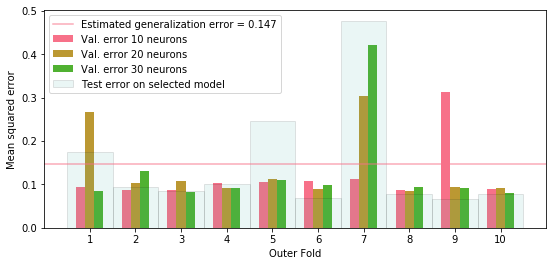

In [230]:
# Results of 2-layer CV on neural net
width = 0.2
x_ = np.arange(1, K+1)

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(x_-width, nn10, width, label='Val. error 10 neurons')
ax.bar(x_, nn20, width, label='Val. error 20 neurons')
ax.bar(x_+width, nn30, width, label='Val. error 30 neurons')
ax.bar(x_, list(MSE_flat), width*5, edgecolor='k',
       alpha = 0.1, label='Test error on selected model')
ax.axhline(MSE.mean(), alpha = 0.6, label='Estimated generalization error = '\
           +str(round(MSE.mean(), 3)))
ax.set(#title='ANN 2-layer cross-validation \n(inner folds: 4)', 
       xlabel='Outer Fold', xticks=x_, ylabel='Mean squared error');
plt.legend();
plt.savefig('2-layer_CV_ANN_results.png', dpi = 300)

### Evaluate performance against a base case

Base case: guessing the mean value of 'usd_pledged_real'

In [239]:
# baseline performance
pledged_mean = df['usd_pledged_real'].mean()

base_error = ((pledged_mean - df['usd_pledged_real'])**2).sum()/len(df['usd_pledged_real'])
print('Guessing the mean value of "usd_pledged_real" (', np.round(pledged_mean, 3), \
') \nresults in a baseline mean squared error of: ', np.round(base_error, 3))

Guessing the mean value of "usd_pledged_real" ( 2.66 ) 
results in a baseline mean squared error of:  2.027


With the ANN having __estimated generalization error of 0.147__ this baseline is outperformed by an order of magnitude.